In [1]:
import os

def traverse_folders(root_folder):
    folder_dict={}
    for root,dirs,files in os.walk(root_folder):
        folder_name = os.path.basename(root)
        file_paths = [os.path.join(root,name ) for name in files]
        if file_paths:
            folder_dict[folder_name] = file_paths
    return folder_dict
root_folder = r"C:\Users\ASUS\Desktop\VS code\Web\SOLO\AgriBott\model\plantvillage dataset\color"
folder_contents = traverse_folders(root_folder)
class_dict = {}
count = 0
for disease_name in folder_contents.keys():
    class_dict[disease_name] = count
    count = count + 1


In [3]:
image_paths = []
image_labels = []

for class_name, paths in folder_contents.items():
    label = class_dict[class_name]
    for path in paths[:300]:  # limit to 300 per class
        image_paths.append(path)
        image_labels.append(label)


In [5]:
import tensorflow as tf

path_ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))


("path/to/image.jpg", 7)


In [6]:
def process_path(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    num_classes = len(class_dict)
    label = tf.one_hot(label, depth=num_classes)
    return img, label
AUTOTUNE = tf.data.AUTOTUNE
dataset = path_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [7]:
BATCH_SIZE = 32

dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)


In [8]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, image_labels, test_size=0.1, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.1, random_state=42)

# Repeat the same pipeline with process_path on each split


In [11]:
train_ds_raw = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds_raw = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_ds_raw = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_raw.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds_raw.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds_raw.map(process_path, num_parallel_calls=AUTOTUNE)


In [13]:
BATCH_SIZE = 32

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


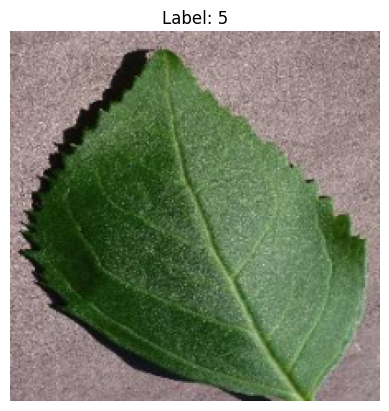

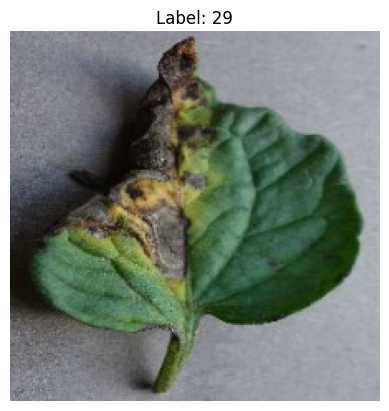

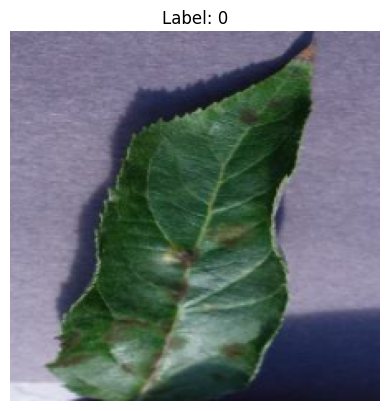

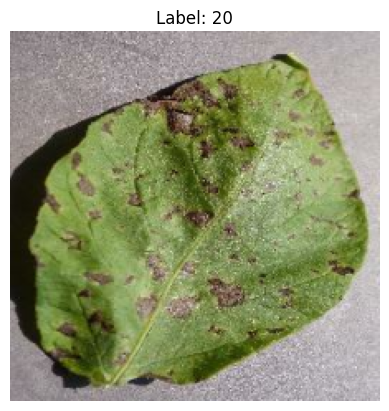

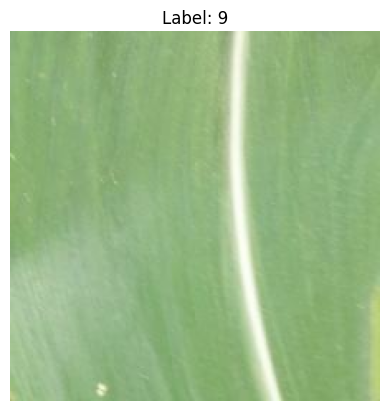

In [15]:
import matplotlib.pyplot as plt
import numpy as np
for images, labels in train_ds.take(1):
    for i in range(5):
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis("off")
        plt.show()


In [24]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(224, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(38, activation='softmax')  
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS = 10  # Or however many epochs you want to train

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)
